In [161]:
using VegaLite
using PlotlyJS
include("./utils.jl")
include("./unit_commitment.jl")
ENV["COLUMNS"]=120 # Set so all columns of DataFrames and Matrices are displayed

color_map=Dict(
    "battery" => "green",
    "solar_photovoltaic" => "gold",
    "onshore_wind_turbine" => "skyblue",
    "hydroelectric_pumped_storage" => "darkblue",
    "small_hydroelectric" => "cornflowerblue",
    "biomass" => "#6fc276",
    "natural_gas_fired_combined_cycle" => "grey",
    "natural_gas_fired_combustion_turbine" => "black",
    "total" => "purple",
    "required" => "#F0092",
)
color_discrete_map = (key) -> if haskey(color_map, key) color_map[key] else "red" end

#3902 (generic function with 1 method)

In [162]:

gen_info, fuels, loads, gen_variable_info, storage_info = read_data()
gen_df = pre_process_generators_data(gen_info, fuels)
storage_df = pre_process_storage_data(storage_info)

# A spring day
n=100
T_period = (n*24+1):((n+1)*24)

# High solar case: 3,500 MW
gen_df_sens = copy(gen_df)
gen_df_sens[gen_df_sens.resource .== "solar_photovoltaic",
    :existing_cap_mw] .= 3500
gen_variable = pre_process_gen_variable(gen_df_sens, gen_variable_info)

# Filtering data with timeseries according to T_period
gen_variable_multi = gen_variable[in.(gen_variable.hour,Ref(T_period)),:];
loads_multi = loads[in.(loads.hour,Ref(T_period)),:];

required_reserve = DataFrame(
    hour = loads[in.(loads.hour, Ref(T_period)), :hour],
    reserve_up_MW = 300 .+ loads[in.(loads.hour,Ref(T_period)), :demand].*0.05,
    reserve_down_MW = loads[in.(loads.hour, Ref(T_period)), :demand].*0.05)


required_energy_reserve = [(row_1.hour, row_2.hour, row_1.reserve_up_MW*(row_1.hour == row_2.hour), row_1.reserve_down_MW*(row_1.hour == row_2.hour)) for row_1 in eachrow(required_reserve), row_2 in eachrow(required_reserve) if row_1.hour <= row_2.hour]
required_energy_reserve = DataFrame(required_energy_reserve)
required_energy_reserve = rename(required_energy_reserve, :1 => :i_hour, :2 => :t_hour, :3 => :reserve_up_MW, :4 => :reserve_down_MW,)
;

### Enriched solution

In [163]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.001,
    ramp_constraints = true,
    storage = storage_df,
    reserve = required_reserve,
    enriched_solution = true);


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.001
Adding ramp constraints...


Adding reserve constraints...


Adding storage...


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 8852 rows, 4776 columns and 22356 nonzeros
Model fingerprint: 0x5ca5e576
Variable types: 2952 continuous, 1824 integer (1824 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e-01, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 5764 rows and 1106 columns
Presolve time: 0.03s
Presolved: 3088 rows, 3670 columns, 14274 nonzeros
Variable types: 1890 continuous, 1780 integer (1780 binary)

Root relaxation: objective 6.473629e+05, 1066 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node  

In [164]:

#TODO: add curtailment to demand

#Supply-demand computation
supply = combine(groupby(solution.generation, [:hour, :resource]), :production_MW => sum, renamecols=false)
demand = combine(groupby(solution.demand, [:hour, :resource]), :demand_MW => sum, renamecols=false)


aux = combine(groupby(solution.generation, [:hour, :resource]), :curtailment_MW => sum, renamecols=false)
replace!(aux.curtailment_MW, missing => 0)
aux = aux[aux.curtailment_MW.>0,:]
rename!(aux, :curtailment_MW => :production_MW)
transform!(aux, :resource .=> ByRow(x -> x*"_curtailment") => :resource)
append!(supply, aux, promote = true)

if haskey(solution,:storage)
    aux = combine(groupby(solution.storage, [:hour, :resource]), [:discharge_MW => sum, :charge_MW => sum], renamecols=false)
    rename!(aux, [:discharge_MW => :production_MW, :charge_MW => :demand_MW])
    append!(supply, aux[!,[:hour, :resource, :production_MW]])
    append!(demand,  aux[!,[:hour, :resource, :demand_MW]], promote = true)
end

aux = solution.generation[!,[:r_id, :hour,:resource,:reserve_up_MW, :reserve_down_MW]]
replace!([aux.reserve_up_MW, missing => 0, aux.reserve_up_MW, missing => 0])
# replace!(aux.reserve_down_MW, missing => 0)
reserve = combine(groupby(aux, [:hour, :resource]), [:reserve_up_MW => sum,:reserve_down_MW => sum], renamecols=false)

reserve_ = copy(reserve)
aux = required_reserve
aux.resource.= "required"
append!(reserve_, aux)
;

# total = combine(groupby(aux, [:hour]), [:reserve_up_MW => sum,:reserve_down_MW => sum], renamecols=false)
# replace!(total.reserve_up_MW, missing => 0)
# replace!(total.reserve_up_MW, missing => 0)
# total.resource .= "total"
# append!(reserve,total)

# reserve = stack(reserve, [:reserve_up_MW, :reserve_down_MW], variable_name = :reserve_type)

# aux = stack(required_reserve, [:reserve_up_MW,:reserve_down_MW],variable_name = :reserve_type)
# aux = required_reserve
# aux.resource.= "required"
# append!(reserve, aux)


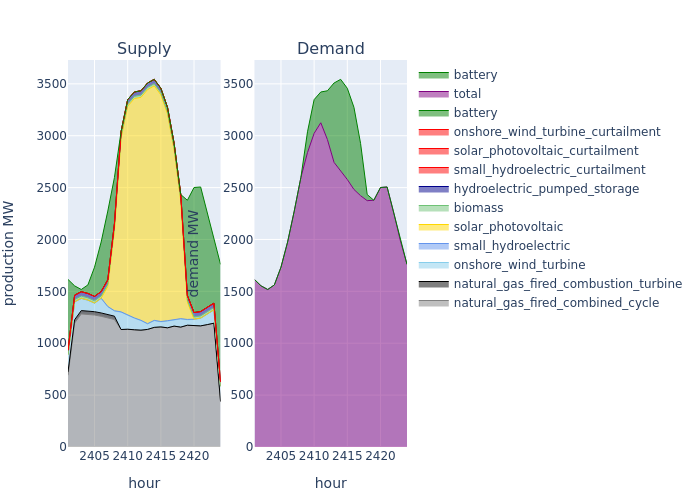

In [165]:
plots1 = [
    scatter(
        x= supply[supply.resource .== r,:].hour, y=supply[supply.resource .== r,:].production_MW,
        stackgroup="one", mode="lines", name = r,
        line=attr(width=1, color=color_discrete_map(r), shape = "line")
    ) for r in unique(supply.resource)
]
plots2 = [
    scatter(
        x= demand[demand.resource .== r,:].hour, y=demand[demand.resource .== r,:].demand_MW,
        stackgroup="one", mode="lines", name = r,
        line=attr(width=1, color=color_discrete_map(r), shape = "line")
    ) for r in unique(demand.resource)
]
p1 = plot(plots1, Layout(yaxis_title="production MW", xaxis_title="hour", title = "Supply")
)
p2 =  plot(plots2, Layout(yaxis_title="demand MW", xaxis_title="hour", title = "Demand")
)
p = [p1 p2]
relayout!(p)
p

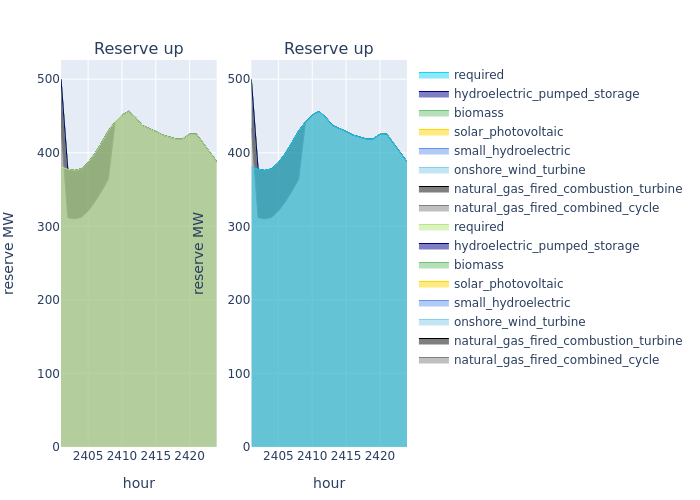

In [166]:

map_stack_group = (x, exclude) -> 1*(x != exclude) + 2*(x == exclude)
p3 = plot([
    scatter(
        x= reserve_[reserve_.resource .== r,:].hour, y=reserve_[reserve_.resource .== r,:].reserve_up_MW,
        stackgroup=map_stack_group(r,"required"), mode="lines", name = r,
        line=attr(width=1, color=color_discrete_map(r), shape = "line")
    ) for r in unique(reserve_.resource)
    ],
    Layout(yaxis_title="reserve MW", xaxis_title="hour", title = "Reserve up")
)


p4 = plot([
    scatter(
        x= reserve_[reserve_.resource .== r,:].hour, y=reserve_[reserve_.resource .== r,:].reserve_down_MW,
        stackgroup=map_stack_group(r,"required"), mode="lines", name = r,
        line=attr(width=1, color=color_discrete_map(r), shape = "line")
    ) for r in unique(reserve_.resource)
    ],
    Layout(yaxis_title="reserve MW", xaxis_title="hour", title = "Reserve down")
)
p = [p3 p3]
relayout!(p)
p

# plot(reserve, x = :hour, y = :value, facet_col = :reserve_type, color = :resource)